# Preprocessing Steps
1. Define bad and dead channels
    - note: manual inspection first? The authors seemed to go in loops and find the bad channels after all the preprocessing are done (artifacts found in autorejects and IC rejections)
For (each participant):
2. Downsample (1000Hz -> 250Hz)
    - note: original data has 260Hz low pass filter
3. Bandpass Filter (0.1, 30Hz)
4. Remove 50Hz. Original paper: notch Filter (50Hz (48, 52, 1))
5. Remove bad channels (if more than 4: remove participant)
6. Rerefenrence (mastoid)
7. Isolate some data to run ICA (epoching? starting with each new cue)
8. Remove bad trials (find artifacts)
9. Run ICA
10. Perform auto-rejection per ICLabel
11. Interpolation

>NOTE: two-pass preprocessing: go through the preprocessing steps once and then see if there is still bad channels remaining. if so, mark them and start over again.

**NOTES**
- nonLearners = [3 5 9 12 20 24 25 29 30 32 33]

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
from mne.io import RawArray
from mne_icalabel import label_components
from meegkit.dss import dss_line
import sys
sys.path.insert(0,'.')
import os
import ccs_eeg_utils
from matplotlib import pyplot as plt
import numpy as np
from find_trial_artifact import find_artifacts
from scipy.stats import trim_mean

from visualization import show_single_psd, psd_compare
from s01_downsample_filter import down_sampling, band_filter, notch_filter, zapline_filter
from s02_bad_channels import drop_bad_channels, reref

# Load the dataset

In [2]:
'''Zheng path'''
#bids_root = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\reward_dataset\\reward_dataset\\reward_dataset"

'''Qian path'''
bids_root = "/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset"

subject_id = '27'

bids_path = BIDSPath(subject=subject_id, task='casinos',
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_56834/2375533191.py:14: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


In [3]:
### Examine the raw data, manually mark the bad channels?
#raw.plot()
#raw.get_data()  # extract data as numpy
raw.load_data()  # load to memory

Reading 0 ... 3161619  =      0.000 ...  3161.619 secs...


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

>NOTE: from manual inspection, Fp1 and Fp2 have obvious eye blinking artifacts. T7 and T8 seem to have muscle artifacts. (but leave it as it is right now)

# Add Reference

>NOTE: not necessary in MNE. will cause problem for build-in artifact detection 

In [4]:
# # add reference channel for site 2
# info_fz = mne.create_info(
#     ch_names=['Fz'],
#     sfreq=raw.info['sfreq'],
#     ch_types=['eeg']
# )

# # create zero-filled data array for Fz
# n_times = raw.n_times
# zeros_data = np.zeros((1,n_times)) # (num_channels, num_times)
# raw_fz = RawArray(zeros_data, info_fz)

# # merge with original data
# raw.add_channels([raw_fz], force_update_info=True)
# print("Fz channel successfully added to the continuous data.")

# raw.plot()


Refenrence channel shows up as a straight line on the plot
>Q: how is refenrence channel used in the later analysis?

# Set the Montage

In [4]:
#NOTE: download .locs file from author's Github, put it under root_of_dataset/code/..
locs_filename = 'site2channellocations.locs'
locs_path = os.path.join(bids_root, 'code', locs_filename)      
custom_montage = mne.channels.read_custom_montage(locs_path)
raw.set_montage(custom_montage, match_case=False)

<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

# Downsample

In [35]:
eeg_down = down_sampling(raw)

Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz


# Bandpass

In [36]:
eeg_band = band_filter(eeg_down)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



# Remove 50Hz Noise

## Option 1: Notch filter

Original setting:  `EEG = pop_eegfiltnew(EEG, 48, 52,[],1)`

In [37]:
eeg_band_notch = notch_filter(eeg_band)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



## Option 2: Zapline filter

In [38]:
eeg_band_zap = zapline_filter(eeg_band)

# for sanity test
#NOTE: when applied on the downsample eeg (not band filtered), zapline does remove the peak at 50Hz (check if zapline is really working)
eeg_down_zap = zapline_filter(eeg_down)


Power of components removed by DSS: 0.00
Power of components removed by DSS: 0.00


# Examine the Effect of Filtering

## Raw vs. Downsampled vs. Bandpass-filtered

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


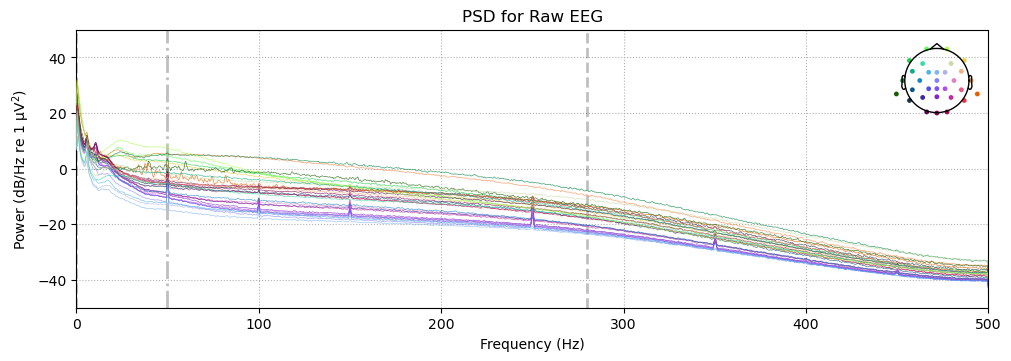

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


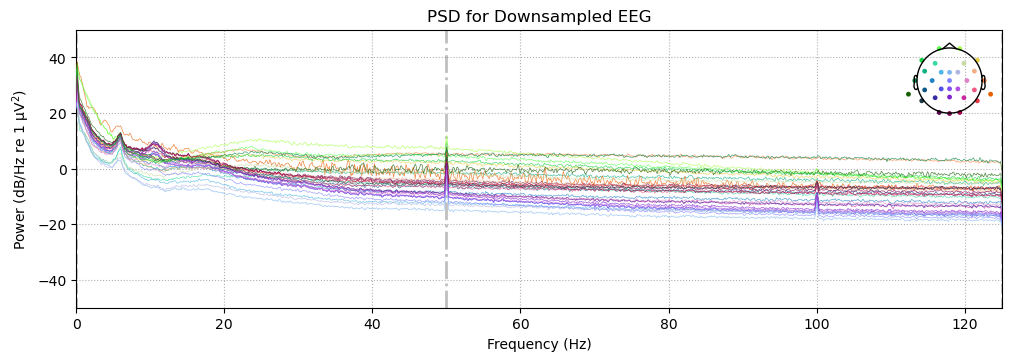

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


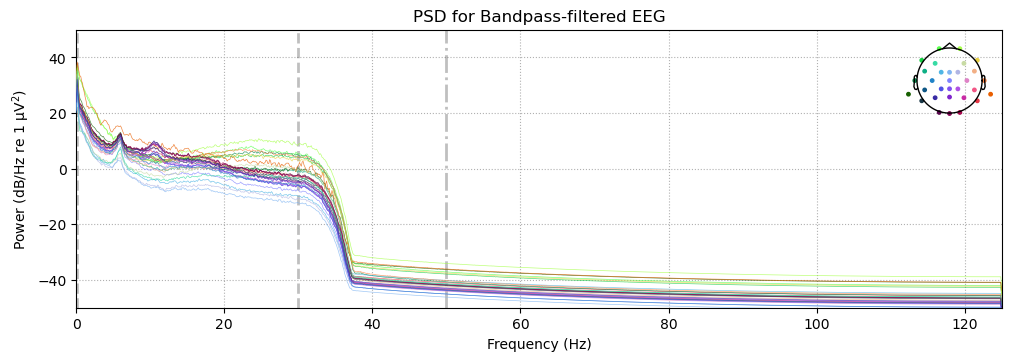

In [39]:
show_single_psd(raw, title="PSD for Raw EEG")
show_single_psd(eeg_down, title="PSD for Downsampled EEG")
show_single_psd(eeg_band, title="PSD for Bandpass-filtered EEG")


>NOTE: as shown on the plot, after band filter the line noise at 50Hz is barely visible

## Bandpass-filtered vs. Band+Notch vs. Band+Zapline

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


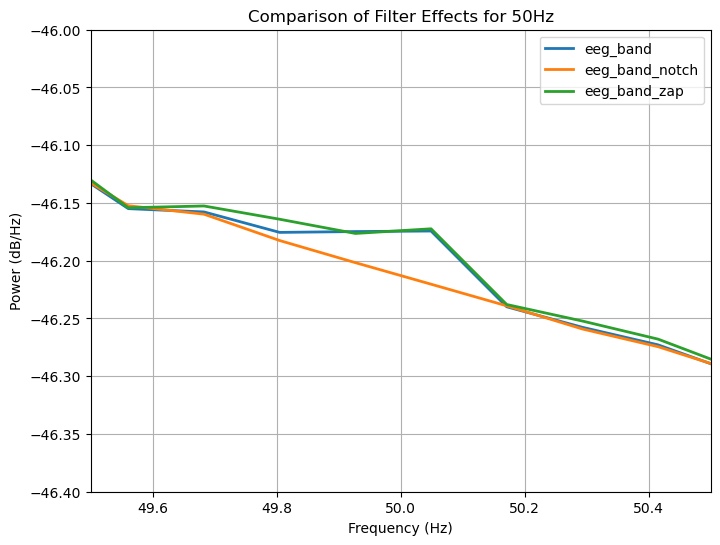

In [40]:
psd_compare((eeg_band, eeg_band_notch, eeg_band_zap), labels=("eeg_band", "eeg_band_notch", "eeg_band_zap"), title="Comparison of Filter Effects for 50Hz")

>NOTE: The leftover noise on 50Hz is negaligable and Zapline is not doing much after the bandpass filter. Choose notch?

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


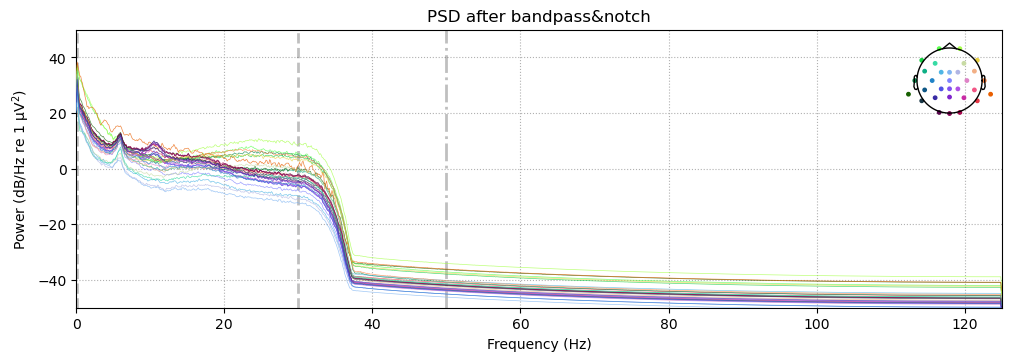

In [13]:
show_single_psd(eeg_band_notch, title="PSD after bandpass&notch")

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


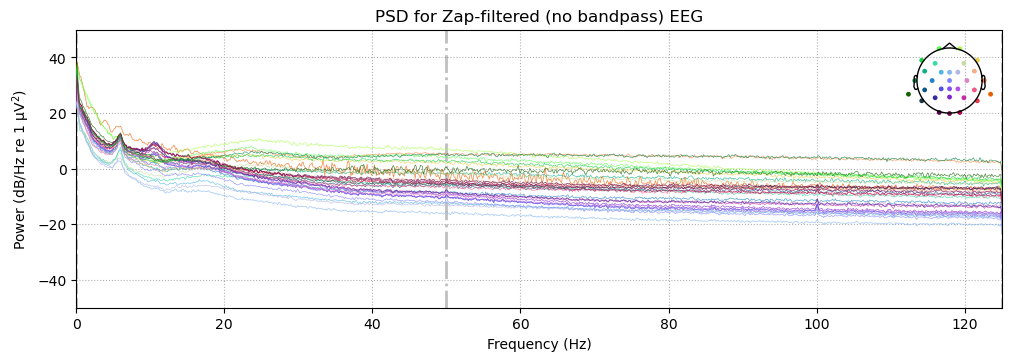

In [14]:
show_single_psd(eeg_down_zap, title="PSD for Zap-filtered (no bandpass) EEG")     # show that zapline can indeed remove 50Hz effectively if there is no bandpass applied before it

In [15]:
#eeg_band_notch.plot()

# Add Bad Channels

>NOTE: not quite sure but i think they dropped the bad channel for ICA analysis, but need a copy (with bad channels) for interpolation

(need to re ananlysie after setting a random seed for ICA)

- subj 27: None
- subj 28: Fp1
- subj 35: TP9

In [45]:
eeg_ica = drop_bad_channels(subject_id, eeg_band_notch)

# Re-referencing

>NOTE: tba - reason for choosing mastoid

In [ ]:
eeg_ica = reref(eeg_ica)

Re-referencing to average of mastoids (TP9, TP10).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


# Cleaning in Time (Trial Rejection)

In [18]:
# split the data into tirals (starts from the onset of fixation thingy)
evts, evts_dict = mne.events_from_annotations(eeg_ica)
#print(evts_dict)
evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]


## Option 1: stick to the original w/ customized auto-reject script

In [19]:
trials_ori = mne.Epochs(eeg_ica, evts, evts_dict_stim, tmin=0, tmax=3, baseline=None)    #NOTE: from 0s to 3s. maybe extend the window?
print(trials_ori.get_data().shape)

Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped
(432, 31, 751)


In [20]:
#NOTE: parameters used are the same as the author, may consider changing them
is_artifacts = np.any(find_artifacts(trials_ori), axis=1).squeeze()
# get the indices of trials of artifacts
is_artifacts_idx = np.where(is_artifacts)[0]
#print(len(is_artifacts_idx))

# drop bad trials
trials_ori.copy().drop(is_artifacts_idx)

Using data from preloaded Raw for 432 events and 751 original time points ...
Dropped 22 epochs: 0, 230, 240, 261, 266, 270, 276, 277, 278, 279, 282, 283, 284, 285, 286, 287, 310, 316, 327, 332, 335, 384


<Epochs | 410 events (all good), 0 – 3 s (baseline off), ~42 KiB, data not loaded,
 np.str_('Stimulus:S  1'): 143
 np.str_('Stimulus:S 11'): 64
 np.str_('Stimulus:S 21'): 65
 np.str_('Stimulus:S 31'): 138>

## Option 2: leveraging MNE methods (no gradient tho)

In [21]:
### peak-to-peak amp check
reject_criteria = dict(
    eeg=500e-6
)

### peak-to-peak min check
flat_criteria = dict(
    eeg=0.1e-6
)

trials = mne.Epochs(
    eeg_ica, 
    evts,
    evts_dict_stim,
    tmin=0, 
    tmax=3, 
    reject=reject_criteria,        
    flat=flat_criteria,
    baseline=None,            
    # reject_by_annotation=True if there are segments marked as 'BAD'  
    preload=True
)

# Check which trials were dropped and why
# print(trials.drop_log)
trials.plot_drop_log();

Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped


# ICA analysis

Difference between 3 ICA methods:
- Runica
- Picard
- Fastica

>NOTE: need to add random seed, for ICA calculation introduce randomness and the results may be different every time

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Fitting ICA took 25.5s.


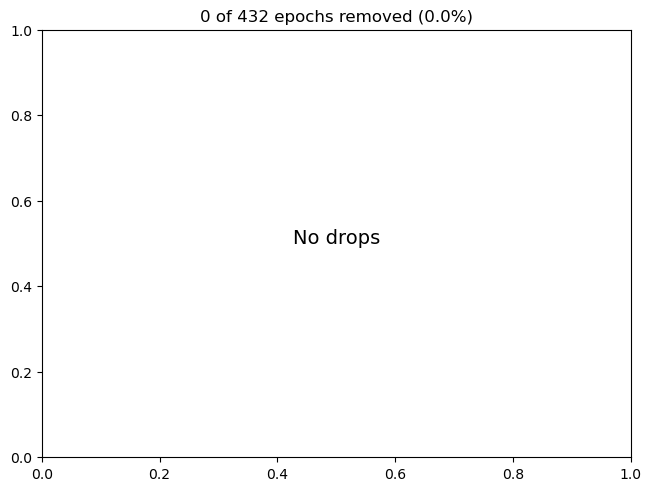

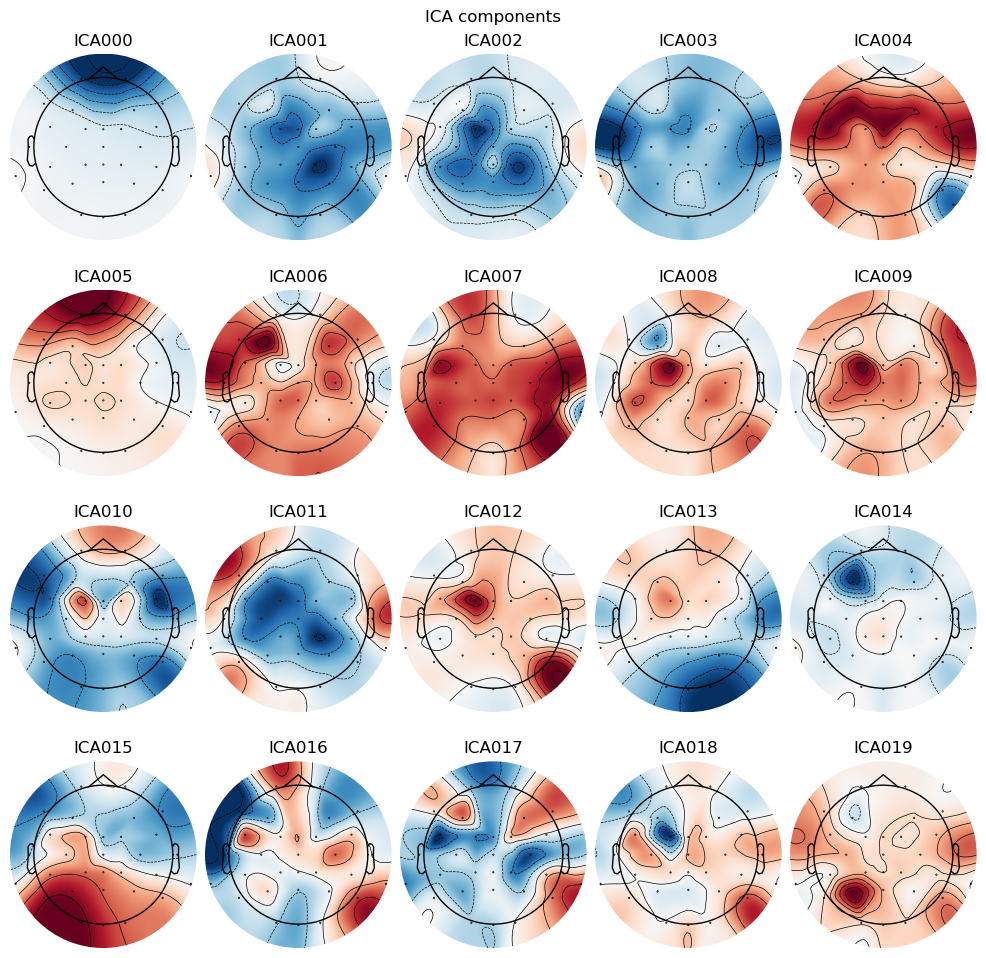

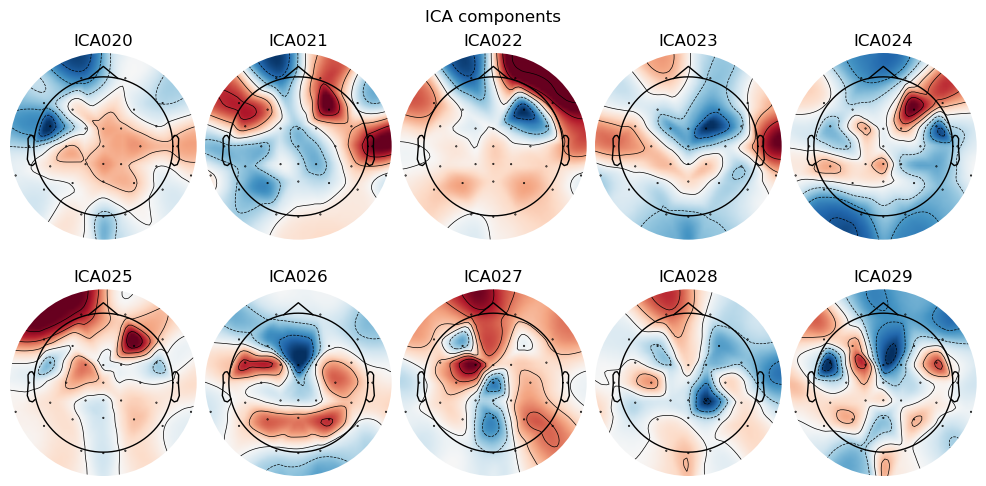

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [22]:
ica = mne.preprocessing.ICA(method="picard")
ica.fit(trials,verbose=True)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated


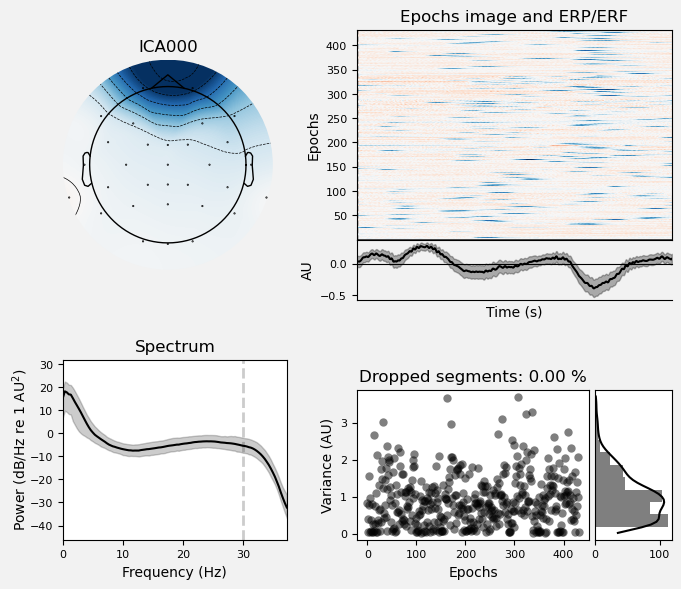

[<Figure size 700x600 with 6 Axes>]

In [23]:
#NOTE: manual inspection. We are using automatic IC rejection?
ica.plot_properties(trials,picks=[0])

# IC Label

In [24]:
# IC_label expects filtered between 1 and 100 Hz, reference to be common average and ica method to be infomax
# so it's better to combine the result of autolabel and munual check in our case
trials.load_data()
ic_labels = label_components(trials, ica, method='iclabel')

print(ic_labels['labels'])
print(ic_labels['y_pred_proba'])
print("numbe of labels:", len(ic_labels['labels']))

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_36538/4259037367.py:4: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method='iclabel')
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_36538/4259037367.py:4: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method='iclabel')


['eye blink', 'brain', 'brain', 'other', 'brain', 'eye blink', 'other', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'other', 'brain', 'brain', 'other', 'other', 'muscle artifact', 'other', 'other', 'other', 'other', 'other', 'other', 'other']
[0.96243215 0.7858996  0.9384278  0.83654684 0.6402743  0.6786914
 0.914885   0.61032563 0.8806158  0.5102171  0.31584167 0.61498225
 0.6794123  0.8394749  0.47214627 0.9937886  0.8386402  0.9212003
 0.6260747  0.6600055  0.8980515  0.8740964  0.52999383 0.7556989
 0.9425005  0.95621765 0.48460445 0.7609507  0.81327504 0.9958784 ]
numbe of labels: 30


/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_36538/105353859.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)


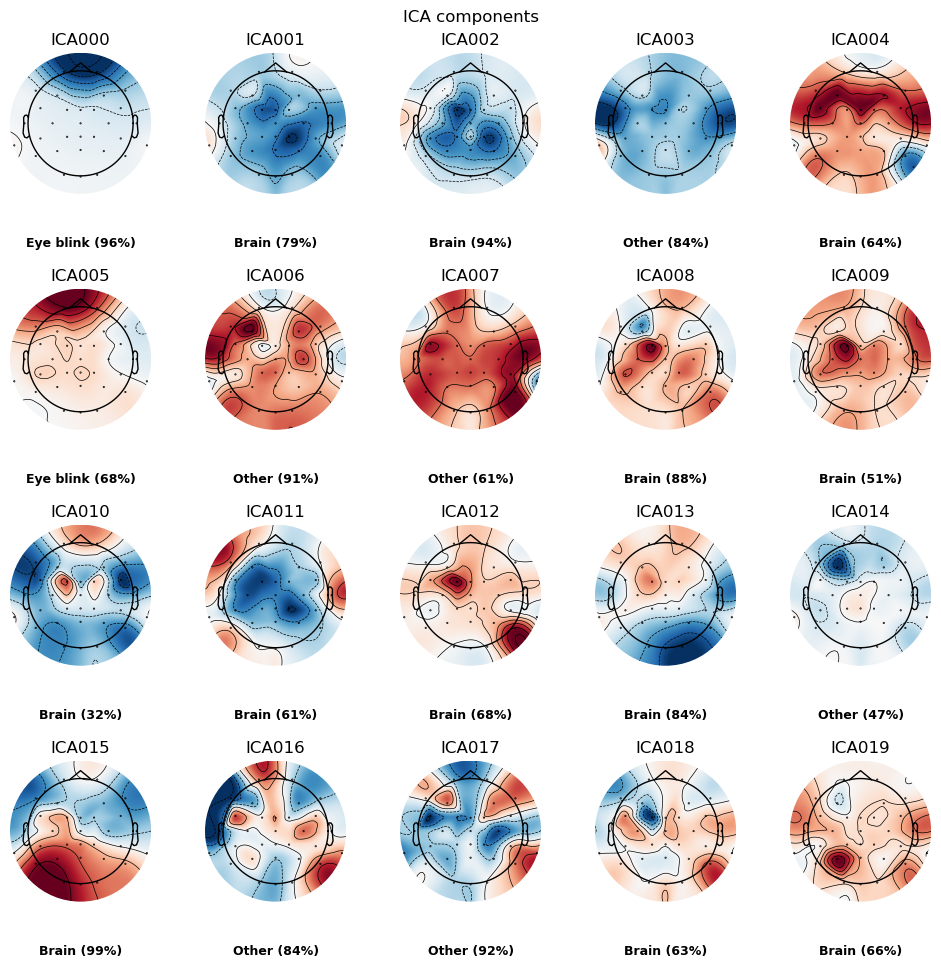

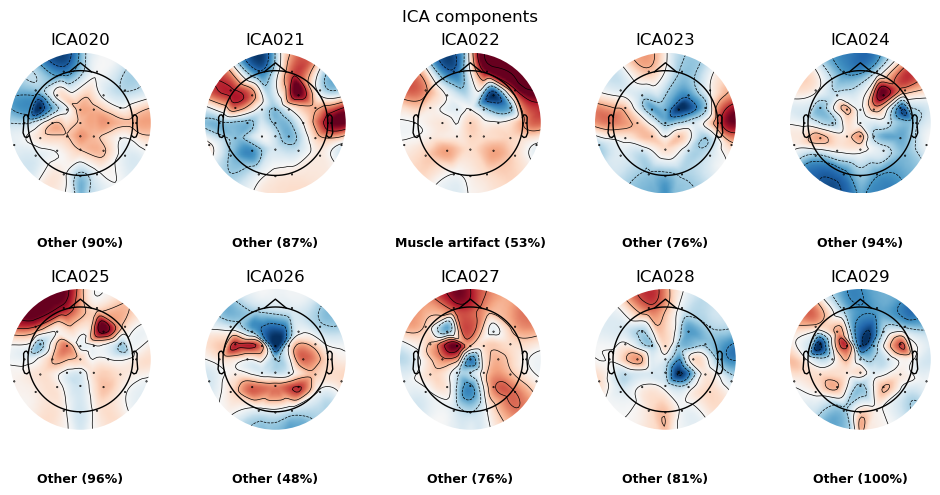

In [25]:
# visualization of ic label with corresponding scalp picture
labels = ic_labels['labels'] 
probs = ic_labels['y_pred_proba'] 

# plot out scalp picture and the auto ic label
titles = []
for i, label in enumerate(labels):
    probability = np.max(probs[i])
    
    title = f"{label.capitalize()} ({probability:.0%})"
    titles.append(title)


figs = ica.plot_components(inst=trials, show=False)

if not isinstance(figs, list):
    figs = [figs]

comp_idx = 0
for fig in figs:
    fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)
    for ax in fig.axes:
        if comp_idx >= len(titles):
            break
            
        ax.text(0.5, -0.3, titles[comp_idx], 
                transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, color='black', fontweight='bold')
        
        comp_idx += 1

plt.show()

>NOTE: 
- subj 35 has high heartbeat component. consider to remove (show up as regular troughs on the eeg graph?).
- the authors only removed eye component, whenever the probability is greater than that of brain.

In [26]:
### exclude the bad IC components and reconstruct the eeg data
# authors only remove eye components and leaves other intact
# criteria: confidence > 80%
exclude_idx = []
for i, label in enumerate(labels):
    #print(label)
    if label == 'eye blink' and probs[i] > 0.5:
        exclude_idx.append(i)

ica.exclude = exclude_idx
ica.apply(eeg_band_notch)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 790405 (3161.6 s), ~187.0 MiB, data loaded>

# Interpolation

> NOTE:
- maybe stick to the locs of site 2 for better accuracy (not necessery to align with site 1) 
- also maybe no need to remove extra channels as well

In [27]:
# # intepolation
# common_montage_path = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\common.locs"
# montage_common = mne.channels.read_custom_montage(common_montage_path)
# eeg_band_notch.set_montage(montage_common, on_missing='ignore') 

if len(eeg_band_notch.info['bads']) > 0:
    print(f"Interpolating bad channels: {eeg_band_notch.info['bads']}")
    eeg_band_notch.interpolate_bads(reset_bads=True)
else:
    print("No bad channels marked for interpolation")

No bad channels marked for interpolation


# Compare EEG before and after preprocessing

In [29]:
raw.plot()

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass


Using pyopengl with version 3.1.10


<mne_qt_browser._pg_figure.MNEQtBrowser(0x410e5fcd0) at 0x410bdd600>

In [ ]:
eeg_band_notch.plot()

# Misc

## Remove extra channels from site 2

In [31]:
# # for participants of site 2, need to remove ['O1','O2','CPz'] channels to make sure it has same num of channels as site 1
# channels_to_remove = ['O1','O2','CPz']
# eeg_band_notch.drop_channels(channels_to_remove, on_missing='ignore')

# # left 29 channels which is different from what they have stated in make_erp (they set 30 channels)

## Remove the first few trials from each task

>NOTE:
- author: remove the first 10. do we stick to it?

In [32]:
def exclude_early_trials(data, num_to_exclude=10):
    """
    Exclude first few trials (default: 10)
        'S  1' = start of low-value task fixation (all low cue)
        'S 11' = start of mixed task fixation(low cue)
        'S 21' = start of mixed task fixation(high cue)
        'S 31' = start of high-value task fixation(all high cue)
    """
    events, event_dict = mne.events_from_annotations(data)
    
    # trial counts per task type
    trial_count = {'S 1': 0, 'S 11_S 21': 0, 'S 31': 0}

    task_start_ids = {}
    
    # Find the event ID for task starters so that we could know when one trial stops
    for event_name, event_id in event_dict.items():
        if 'Stimulus:S  1' == event_name:
            task_start_ids['S 1'] = [event_id]
        elif 'Stimulus:S 11' == event_name or 'Stimulus:S 21'== event_name:
            if 'S 11_S 21' not in task_start_ids: 
                task_start_ids['S 11_S 21'] = []
            task_start_ids['S 11_S 21'].append(event_id)
        elif 'Stimulus:S 31' == event_name:
            task_start_ids['S 31'] = [event_id]
    print(task_start_ids)

    # flatten all start ids
    all_task_starts = []
    for ids in task_start_ids.values():
        all_task_starts.extend(ids)
    print(all_task_starts)

    events_to_exclude = []
    i = 0
    while i < len(events):
        event_id = events[i, 2] # ith event's eventid (2 means event id)
        
        # Determine if this event marks the start of a trial
        current_task_type = None
        if 'S 1' in task_start_ids and event_id in task_start_ids['S 1']:
            current_task_type = 'S 1'
        elif 'S 11_S 21' in task_start_ids and event_id in task_start_ids['S 11_S 21']:
            current_task_type = 'S 11_S 21'
        elif 'S 31' in task_start_ids and event_id in task_start_ids['S 31']:
            current_task_type = 'S 31'

        # If it is a trial start
        if current_task_type is not None:
            # Check if the trial should be excluded
            if trial_count[current_task_type] < num_to_exclude:
                events_to_exclude.append(i)
                
                # Mark subsequent events until the next trial starts
                j = 1
                while (i + j) < len(events):
                    next_id = events[i + j, 2]
                    if next_id in all_task_starts:
                        break 
                    events_to_exclude.append(i + j)
                    j += 1
            
            trial_count[current_task_type] += 1
        
        i += 1
    print(trial_count)

    # Remove excluded events
    if events_to_exclude:
        # Create mask: True = keep, False = exclude
        keep_mask = np.ones(len(events), dtype=bool)
        keep_mask[events_to_exclude] = False

        # Keep only non-excluded events
        events_filtered = events[keep_mask]

        data_clean = data.copy()
        
        # Add back the filtered events
        new_annot = mne.annotations_from_events(
            events_filtered,
            data_clean.info['sfreq'],
            event_desc={v: k for k, v in event_dict.items()}
        )
        data_clean.set_annotations(new_annot)
        
        print(f"Excluded {len(events_to_exclude)} events (first {num_to_exclude} trials of each block).")
        return data_clean
    else:
        print("No trials excluded.")
        return data.copy()



In [33]:
eeg_final = exclude_early_trials(eeg_band_notch, num_to_exclude=10)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1': [10002], 'S 11_S 21': [10009, 10016], 'S 31': [10023]}
[10002, 10009, 10016, 10023]
{'S 1': 144, 'S 11_S 21': 144, 'S 31': 144}
Excluded 148 events (first 10 trials of each block).


>NOTE: 
- in theory, 3 tasks x 10 trials x 6 events = 180 events to be exlude
- but there might be some invalid response or to fast/slow reponses that do not have response/feedback

In [34]:
events, event_id = mne.events_from_annotations(eeg_final)
print(event_id)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{np.str_('Comment:Active Shielding: On'): 10001, np.str_('Stimulus:S  1'): 10002, np.str_('Stimulus:S  2'): 10003, np.str_('Stimulus:S  3'): 10004, np.str_('Stimulus:S  4'): 10005, np.str_('Stimulus:

# Epoching & find leftover artifacts

In [35]:
CONDITIONS_DICT = {
    # Cue-Locked Conditions
    # 'lowP-uniform':  ['Stimulus:S  2'],
    # 'lowP-mixed':    ['Stimulus:S 12'],
    # 'highP-mixed':   ['Stimulus:S 22'],
    # 'highP-uniform': ['Stimulus:S 32'],

    # Feedback-Locked Conditions
    'Low-Low Win':   ['Stimulus:S  6'], 
    'Low-Low Loss':  ['Stimulus:S  7'], 
    'Mid-Low Win':   ['Stimulus:S 16'], 
    'Mid-Low Loss':  ['Stimulus:S 17'], 
    'Mid-High Win':  ['Stimulus:S 26'], 
    'Mid-High Loss': ['Stimulus:S 27'],
    'High-High Win': ['Stimulus:S 36'], 
    'High-High Loss':['Stimulus:S 37'],

    # # Win-Loss Conditions
    # 'All Win':  ['Stimulus:S  6', 'Stimulus:S 16', 'Stimulus:S 26', 'Stimulus:S 36'],
    # 'All Loss': ['Stimulus:S  7', 'Stimulus:S 17', 'Stimulus:S 27', 'Stimulus:S 37']
}

all_markers = []
for markers in CONDITIONS_DICT.values():
    all_markers.extend(markers)

# Create the filtered event dictionary
evts_dict_stim = {k: event_id[k] for k in event_id.keys() if k in all_markers}

**Round 1**: if met the channel dropping criteria: mark as bad channel. \
**Round 2**: drop the bad epochs directly

In [36]:
reject_criteria = dict(eeg=150e-6)
flat_criteria = dict(eeg=0.1e-6)
REJECTION_RATE_THRESHOLD = 0.20

In [37]:
epochs_all = mne.Epochs(
    eeg_final, 
    events, 
    evts_dict_stim, 
    tmin=-0.2, 
    tmax=0.6, 
    reject=reject_criteria, 
    flat=flat_criteria,
    baseline=(-0.2, 0),
    preload=True,
)

Not setting metadata
398 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 398 events and 201 original time points ...
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['TP9']
7 bad epochs dropped


In [38]:
# Get the drop log which lists the channels responsible for each drop
drop_log = epochs_all.drop_log

# Initialize a dictionary to count how many times each channel caused a drop
channel_drop_counts = {}
n_total_epochs = len(epochs_all.events)
ch_names = epochs_all.ch_names

# Iterate through the drop log and count
for reasons in drop_log:
    # 'reasons' is a tuple of channel names (e.g., ('Fz', 'T7') or ())
    if reasons:  # Only process epochs that were actually dropped
        for ch_name in reasons:
            channel_drop_counts[ch_name] = channel_drop_counts.get(ch_name, 0) + 1

# Identify channels whose rejection rate exceeds the 20% threshold
bad_channels_to_mark = []
print("--- Channel Rejection Summary ---")

for ch_name in ch_names:
    # Use .get() to handle channels that never caused a drop (count = 0)
    drop_count = channel_drop_counts.get(ch_name, 0)
    rejection_rate = drop_count / n_total_epochs

    print(f"{ch_name}: {drop_count}/{n_total_epochs} drops ({rejection_rate:.1%})")

    if rejection_rate > REJECTION_RATE_THRESHOLD:
        bad_channels_to_mark.append(ch_name)

print("---------------------------------")
print(f"Channels exceeding {REJECTION_RATE_THRESHOLD:.0%} threshold: {bad_channels_to_mark}")

--- Channel Rejection Summary ---
Fp1: 0/391 drops (0.0%)
F3: 0/391 drops (0.0%)
F7: 0/391 drops (0.0%)
FC5: 0/391 drops (0.0%)
FC1: 0/391 drops (0.0%)
FCz: 0/391 drops (0.0%)
C3: 0/391 drops (0.0%)
T7: 0/391 drops (0.0%)
TP9: 2/391 drops (0.5%)
CP5: 0/391 drops (0.0%)
CP1: 0/391 drops (0.0%)
Pz: 0/391 drops (0.0%)
P3: 0/391 drops (0.0%)
P7: 0/391 drops (0.0%)
O1: 2/391 drops (0.5%)
Oz: 2/391 drops (0.5%)
O2: 2/391 drops (0.5%)
P4: 0/391 drops (0.0%)
P8: 0/391 drops (0.0%)
TP10: 4/391 drops (1.0%)
CP6: 0/391 drops (0.0%)
CP2: 0/391 drops (0.0%)
CPz: 0/391 drops (0.0%)
Cz: 0/391 drops (0.0%)
C4: 0/391 drops (0.0%)
T8: 0/391 drops (0.0%)
FC6: 0/391 drops (0.0%)
FC2: 0/391 drops (0.0%)
F4: 0/391 drops (0.0%)
F8: 0/391 drops (0.0%)
Fp2: 0/391 drops (0.0%)
---------------------------------
Channels exceeding 20% threshold: []


In [39]:
# # build new epochs with parameters following authors
# epochs_all = mne.Epochs(
#     eeg_final, 
#     events, 
#     evts_dict_stim, 
#     tmin=-0.2, 
#     tmax=0.6, 
#     baseline=(-0.2, 0),
#     preload=True
# )

# ### Stick to the authors method
# is_artifacts = np.any(find_artifacts(epochs_all, maxMin=150e-6, level=150e-6, step=40e-6,lowest=0.1e-6), axis=1).squeeze()
# is_artifacts_idx = np.where(is_artifacts)[0]
# epochs_all.drop(is_artifacts_idx)

# Make ERP

>NOTE: need double check

In [40]:
# apply trimmed mean

def get_trimmed_mean(epochs, proportiontocut=0.05):
    data = epochs.get_data()
    trimmed_erp_data = np.apply_along_axis(
        trim_mean,
        axis=0, # along the trial axis
        arr=data,
        proportiontocut=proportiontocut
    ) # (n_channels, n_times)
    # Create the final Evoked object
    trimmed_evoked = mne.EvokedArray(
        trimmed_erp_data, 
        epochs.info, 
        tmin=epochs.times[0]
    )
    return trimmed_evoked


In [41]:
all_evokeds = {}
for name, markers in CONDITIONS_DICT.items():
    # Only try to index if the marker exists in the filtered events
    valid_markers_for_cond = [m for m in markers if m in epochs_all.event_id]
    
    if valid_markers_for_cond:
        epochs_cond = epochs_all[valid_markers_for_cond] 
        if len(epochs_cond) > 0:
            erp_cond = get_trimmed_mean(epochs_cond, proportiontocut=0.05)
            all_evokeds[name] = erp_cond
        else:
            print(f"Warning: No epochs found for condition {name}")
    else:
        print(f"Warning: Condition {name} markers not found in epochs.")


In [42]:
# using mean amplitude to measure erp amplitude
def calculate_mean_amplitude(evoked, channel_name, tmin, tmax):
    """Calculates the mean amplitude for a channel within a time window."""
    
    # Select the specific channel
    data = evoked.get_data(picks=channel_name)[0] 
    
    # Get the time indices corresponding to the window (tmin, tmax)
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # calculate the mean across time (axis 1)
    mean_val = np.mean(data[i_start:i_end + 1])
    
    return mean_val * 1e6 # Convert Volts to microvolts (µV)

# using peak-to-peak
def calculate_peak_to_peak(evoked, channel_name, tmin, tmax):
    """
    Calculates peak-to-peak within a single time window.
    Finds the minimum (negative peak) and maximum (positive peak) in the same window.
    """
    data = evoked.get_data(picks=channel_name)[0]
    times = evoked.times
    
    # Single search window for both peaks
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # Find minimum (most negative) and maximum (most positive) in this window
    n_idx = i_start + np.argmin(data[i_start:i_end + 1])
    p_idx = i_start + np.argmax(data[i_start:i_end + 1])
    
    n_amplitude = data[n_idx]
    p_amplitude = data[p_idx]
    n_time = times[n_idx]
    p_time = times[p_idx]
    
    # Peak-to-peak difference
    peak_to_peak = (p_amplitude - n_amplitude) * 1e6
    
    return peak_to_peak, n_time * 1000, p_time* 1000, n_amplitude, p_amplitude

In [43]:
win = [k for k in CONDITIONS_DICT.keys() if 'Win' in k]
loss = [k for k in CONDITIONS_DICT.keys() if 'Loss' in k]
valid_win_names = [name for name in win if name in all_evokeds]
valid_loss_names = [name for name in loss if name in all_evokeds]

if valid_win_names and valid_loss_names:
    # calculate average amplitude for win and lose cases
    win_evokeds_list = [all_evokeds[name] for name in valid_win_names]
    loss_evokeds_list = [all_evokeds[name] for name in valid_loss_names]
    
    erp_grand_win = mne.combine_evoked(win_evokeds_list, weights='equal')
    erp_grand_loss = mne.combine_evoked(loss_evokeds_list, weights='equal')
    rewp_diff = mne.combine_evoked([erp_grand_win, erp_grand_loss], weights=[1, -1])

    # Parameters
    channel = 'FCz'
    mean_window = [0.240, 0.340] # as set by authors

    # Metrics
    rewp_mean_amplitude = calculate_mean_amplitude(rewp_diff, channel, mean_window[0], mean_window[1])
    p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(rewp_diff, channel, mean_window[0], mean_window[1])

 
    print(f"RewP Mean Amplitude: {rewp_mean_amplitude:.2f} µV")
    print(f"RewP Peak-to-Peak: {p2p_amp:.2f} µV")


RewP Mean Amplitude: 0.94 µV
RewP Peak-to-Peak: 1.84 µV


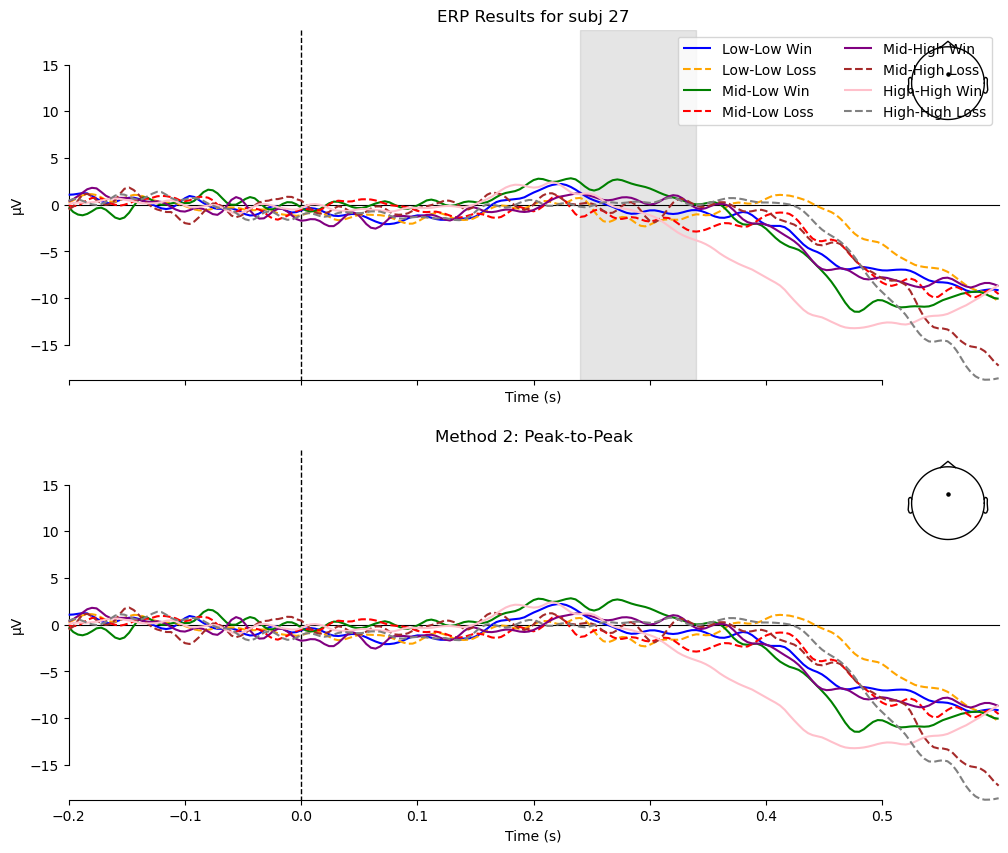

In [44]:
channel = 'FCz'
twindow = [0.240, 0.340]

# Define styles for the plot
colors = {
    'Low-Low Win': 'blue', 'Low-Low Loss': 'orange',
    'Mid-Low Win': 'green', 'Mid-Low Loss': 'red',
    'Mid-High Win': 'purple', 'Mid-High Loss': 'brown',
    'High-High Win': 'pink', 'High-High Loss': 'gray'
}
linestyles = {
    'Low-Low Win': '-', 'Low-Low Loss': '--',
    'Mid-Low Win': '-', 'Mid-Low Loss': '--',
    'Mid-High Win': '-', 'Mid-High Loss': '--',
    'High-High Win': '-', 'High-High Loss': '--'
}

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Subplot 1: Mean Amplitude
mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[channel],
    colors=colors,
    linestyles=linestyles,
    axes=axes[0],
    title=f"ERP Results for subj 27",   #NOTE: to be changed
    legend='upper right',
    ci=True,
    show=False
)
# Add shading for Mean Amplitude window
axes[0].axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label='Mean Window')

# Subplot 2: Peak-to-Peak
mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[channel],
    colors=colors,
    linestyles=linestyles,
    axes=axes[1],
    title=f"Method 2: Peak-to-Peak",
    legend=False, # Legend is same as top
    ci=True,
    show=False
)
plt.show()

# # Iterate through each condition to calculate and plot its specific P2P markers
# for name, evoked in all_evokeds.items():
#     if name in colors: # Only plot if we have a color for it
#         # Calculate P2P for this specific condition
#         p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(
#             evoked, channel, twindow[0], twindow[1]
#         )
        
#         # Plot the markers on the second subplot
#         # We use the condition's specific color for the markers
#         color = colors[name]
        
#         # Negative Peak Marker
#         axes[1].plot(n_time, n_val, marker='v', color=color, markersize=8, alpha=0.7)
#         # Positive Peak Marker
#         axes[1].plot(p_time, p_val, marker='^', color=color, markersize=8, alpha=0.7)
#         # Connecting line
#         axes[1].plot([n_time, p_time], [n_val, p_val], color=color, linestyle=':', alpha=0.5)


#         print(f"{name}: P2P = {p2p_amp:.2f} µV (N: {n_time*1000:.0f}ms, P: {p_time*1000:.0f}ms)")
# axes[1].axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label='Mean Window')
# axes[1].set_xlabel('Time (s)')
# plt.tight_layout()
# plt.show()

In [45]:
print(all_evokeds.keys())

dict_keys(['Low-Low Win', 'Low-Low Loss', 'Mid-Low Win', 'Mid-Low Loss', 'Mid-High Win', 'Mid-High Loss', 'High-High Win', 'High-High Loss'])


Calculated difference for: Low-Low
Calculated difference for: Mid-Low
Calculated difference for: Mid-High
Calculated difference for: High-High


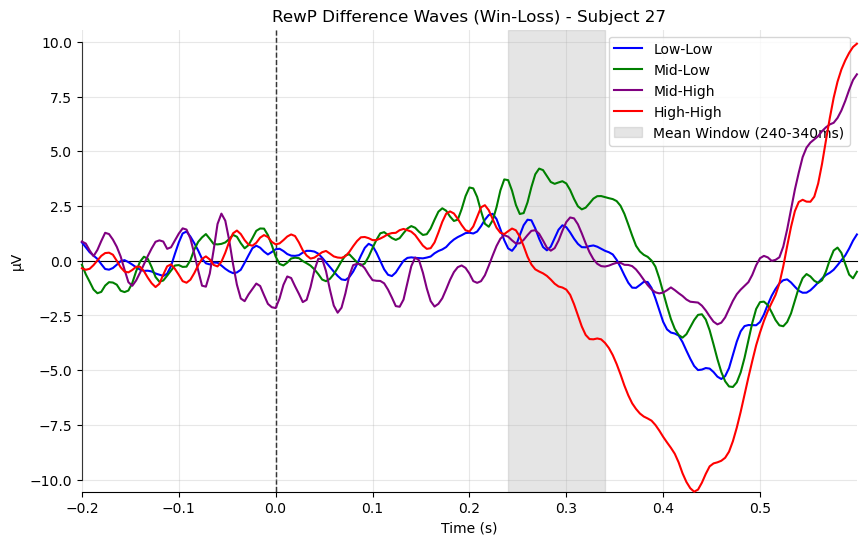

2025-12-14 15:59:25.580 python[36538:2477377] error messaging the mach port for IMKCFRunLoopWakeUpReliable


Channels marked as bad:
none
Channels marked as bad:
none


In [46]:
diff_evokeds = {}

cases = [
    ('Low-Low', 'Low-Low Win', 'Low-Low Loss'),
    ('Mid-Low', 'Mid-Low Win', 'Mid-Low Loss'),
    ('Mid-High', 'Mid-High Win', 'Mid-High Loss'),
    ('High-High', 'High-High Win', 'High-High Loss')
]

for case_name, win_cond, loss_cond in cases:
    if win_cond in all_evokeds and loss_cond in all_evokeds:
        # Calculate Difference: Win - Loss
        diff = mne.combine_evoked(
            [all_evokeds[win_cond], all_evokeds[loss_cond]],
            weights=[1, -1]
        )
        diff.comment = case_name # Set name for plotting
        diff_evokeds[case_name] = diff
        print(f"Calculated difference for: {case_name}")
    else:
        print(f"Warning: Missing conditions for {case_name}. Cannot calculate difference.")

colors_diff = {
    'Low-Low': 'blue',  
    'Mid-Low': 'green',   
    'Mid-High': 'purple',  
    'High-High': 'red'  
}

# FIGURE 1: Mean Amplitude Visualization
fig1, ax1 = plt.subplots(figsize=(10, 6))

mne.viz.plot_compare_evokeds(
    diff_evokeds,
    picks=[channel],
    colors=colors_diff,
    axes=ax1,
    title=f"RewP Difference Waves (Win-Loss) - Subject 27",  #NOTE: to be changed
    legend='upper right',
    show=False,
    show_sensors=False
)

ax1.axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label=f'Mean Window ({mean_window[0]*1000:.0f}-{mean_window[1]*1000:.0f}ms)')
ax1.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


# # FIGURE 2: Peak-to-Peak Amplitude Visualization
# print("\nGenerating Figure 2: Peak-to-Peak Measurement...")
# fig2, ax2 = plt.subplots(figsize=(10, 6))

# mne.viz.plot_compare_evokeds(
#     diff_evokeds,
#     picks=[channel],
#     colors=colors_diff,
#     axes=ax2,
#     title=f"RewP Difference Waves (Win-Loss) - Peak-to-Peak Method",
#     legend='upper right', 
#     show=False
# )

# print("\n--- Calculating and Plotting P2P Markers ---")
# # Create dummy handles for the legend to ensure clean labels

# for name, evoked in diff_evokeds.items():
#     if name in colors_diff:
#         # Calculate P2P for this difference wave
#         p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(
#             evoked, channel, twindow[0], twindow[1]
#         )
        
#         color = colors_diff[name]
#         # Plot markers and connecting line
#         ax2.plot(n_time, n_val, marker='v', color=color, markersize=8, alpha=0.7)
#         ax2.plot(p_time, p_val, marker='^', color=color, markersize=8, alpha=0.7)
#         ax2.plot([n_time, p_time], [n_val, p_val], color=color, linestyle=':', alpha=0.5)

#         print(f"{name} Diff: P2P = {p2p_amp:.2f} µV (N: {n_time*1000:.0f}ms, P: {p_time*1000:.0f}ms)")
# ax2.axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label=f'Mean Window ({mean_window[0]*1000:.0f}-{mean_window[1]*1000:.0f}ms)')
# plt.grid(True, alpha=0.3)
# plt.show()
